In [9]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#import warnings
#warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Constants
UNDEFINED_VALUE = -999.

## WITHOUT SPLITTING THE DATA

In [4]:
%%time
# Load train data and supply path
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

#computing median values for each column (excluding undefined values)
medians = np.apply_along_axis(lambda v: np.median(v[v!=UNDEFINED_VALUE]), 0, tX)

#substituting median instead of undefined values
for col_num in range(tX.shape[1]):
    column = tX[:, col_num]
    column[column == UNDEFINED_VALUE] = medians[col_num]
print("undefined values in dataset: ", UNDEFINED_VALUE in tX)

#standardizing the data
tX -= np.mean(tX, axis = 0)
tX /= np.std(tX, axis = 0)

#weight, loss = ridge_regression(y, tX, 0.01)
weight, loss = least_squares(y, tX)

#loading the test data and creating the groups
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

#substituting median instead of undefined values
for col_num in range(tX.shape[1]):
    column = tX[:, col_num]
    column[column == UNDEFINED_VALUE] = medians[col_num]
print("undefined values in dataset: ", UNDEFINED_VALUE in tX)

#standardizing the data
tX_test -= np.mean(tX_test, axis = 0)
tX_test /= np.std(tX_test, axis = 0)
    
y_pred = predict_labels(weight, tX_test).flatten()

#creating csv file
OUTPUT_PATH = '../data/sample-submission_ls_sans_rien.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

CPU times: user 30.4 s, sys: 2.81 s, total: 33.2 s
Wall time: 32.4 s


## SPLITTING THE DATA BY JET NUMBER

In [40]:
%%time


##############################################################################
#------------------- DATA CLEANING & FEATURE ENGINEERING ---------------------
##############################################################################
# Load train data and supply path
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

#constants definitions
PRI_JET_NUM_IDX = 22   
PRI_JET_NUM_VALUES = range(4)
NUMBER_GROUPS = len(PRI_JET_NUM_VALUES)
NBR_FEATURES = 30
UNDEFINED_VALUE = -999.

#seperating the data within the four groups
jet_groups_indices = [tX[:, PRI_JET_NUM_IDX] == pri_jet_num_value for pri_jet_num_value in PRI_JET_NUM_VALUES]
TX_arr = [tX[group_indices] for group_indices in jet_groups_indices]
Y_arr, TX_arr = zip(*[(y[group_indices], tX[group_indices]) for group_indices in jet_groups_indices])
Y_arr, TX_arr = list(Y_arr), list(TX_arr)

#collecting the indices of the undefined features for each group
#undefined_features = [[], [], [], []]
#for group_idx in range(NUMBER_GROUPS):
#    tx = TX_arr[group_idx]
#    for feature_idx in range(NBR_FEATURES):
#        feature_column = tx[:, feature_idx]
#        if np.all(feature_column == UNDEFINED_VALUE):
#            undefined_features[group_idx].append(feature_idx)
#
##computing the std of the features for each group
#STDS = [np.std(TX_arr[i], axis = 0) for i in range(NUMBER_GROUPS)]
#
##collecting the indices of the features with no variance (i.e. constant features) within each groups
#cst_features = [[], [], [], []]
#for group_idx, elem in enumerate(STDS):
#    for feature_idx, std in enumerate(elem):
#        if std == 0. and feature_idx not in undefined_features[group_idx]:
#            cst_features[group_idx].append(feature_idx)
#
##deleting the features either undefined or with no variance (i.e. constant features) within each groups
#features_to_keep = ([[x for x in range(NBR_FEATURES) 
#                      if x not in undefined_features[group_idx] and x not in cst_features[group_idx]] 
#                      for group_idx in range(NUMBER_GROUPS)])
#TX_arr = [TX_arr[group_idx][:, features_to_keep[group_idx]] for group_idx in range(NUMBER_GROUPS)]
#
## Store the computed medians of the training set
## to be used in the data set when substituing UNDEFINED_VALUES
#train_medians = []
#for group_idx in range(NUMBER_GROUPS):
#    #computing median values for each column (excluding undefined values)
#    medians = np.apply_along_axis(lambda v: np.median(v[v!=UNDEFINED_VALUE]), 0, TX_arr[group_idx])
#    train_medians.append(medians)
#    #substituting median instead of undefined values
#    for col_num in range(TX_arr[group_idx].shape[1]):
#        column = TX_arr[group_idx][:, col_num]
#        column[column == UNDEFINED_VALUE] = medians[col_num]
#    print(f"undefined values in dataset {group_idx} ? ", UNDEFINED_VALUE in TX_arr[group_idx])
#
##standardizing the data
#for tx in TX_arr:
#    tx -= np.mean(tx, axis = 0)
#    tx /= np.std(tx, axis = 0)

    
##############################################################################
#----------------------------- TEST DATA CLEANING ----------------------------
##############################################################################
#loading the test data and creating the groups
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
jet_groups_indices_test = [tX_test[:, PRI_JET_NUM_IDX] == pri_jet_num_value for pri_jet_num_value in PRI_JET_NUM_VALUES]
TX_test_arr = list([tX_test[group_indices] for group_indices in jet_groups_indices_test])

##remove unused features
#TX_test_arr = [TX_test_arr[group_idx][:, features_to_keep[group_idx]] for group_idx in range(NUMBER_GROUPS)]
#
## subsitute UNDEFINED VALUES of the test set by the medians previously computed
#for group_idx in range(NUMBER_GROUPS):
#    #substituting median instead of undefined values
#    for col_num in range(TX_test_arr[group_idx].shape[1]):
#        column = TX_test_arr[group_idx][:, col_num]
#        column[column == UNDEFINED_VALUE] = train_medians[group_idx][col_num]
#    print(f"undefined values in dataset {group_idx} ? ", UNDEFINED_VALUE in TX_test_arr[group_idx])
#
##standardizing the data
#for tx in TX_test_arr:
#    tx -= np.mean(tx, axis = 0)
#    tx /= np.std(tx, axis = 0)

    
##############################################################################
#------------------------------ TRAIN AND PREDICT ----------------------------
##############################################################################
# train model & generate predictions
y_pred=np.empty(tX_test.shape[0])
for group_idx in range(NUMBER_GROUPS):
    weight, loss = ridge_regression(y, tX, 0.01)
    #weight, loss = least_squares(Y_arr[group_idx], TX_arr[group_idx])
    y_pred[jet_groups_indices_test[group_idx]] = predict_labels(weight, TX_test_arr[group_idx]).flatten()

#creating csv file
OUTPUT_PATH = '../data/sample-submission_least_square_19_heures.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

CPU times: user 28.6 s, sys: 1.98 s, total: 30.6 s
Wall time: 29.9 s


<AxesSubplot:>

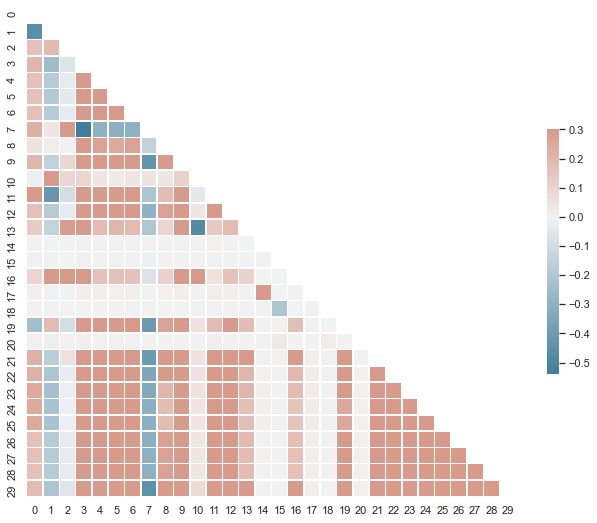

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=tX)

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

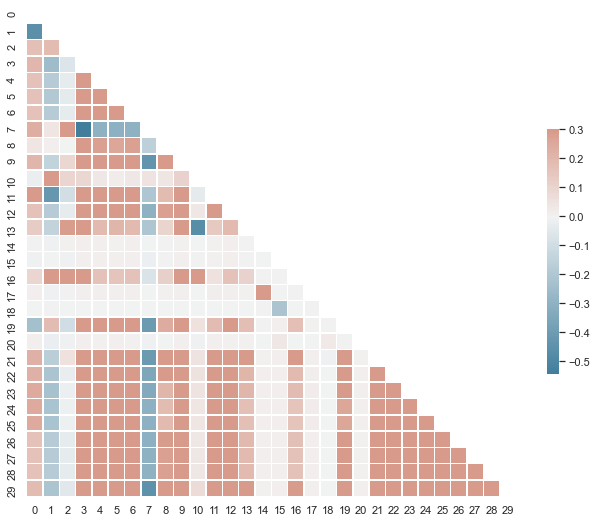

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=tX_test)

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})